**Feature extraction using vgg16**

In [1]:
from IPython.display import IFrame

$\bm{Introduction\  to\  the\  neural\  netwroks\  and\  back\  propagation}$

In [2]:
website_url = "https://theneuralblog.com/forward-pass-backpropagation-example/"
iframe = IFrame(website_url, width="800", height="400")
display(iframe)

$\bm{Introduction\  to\  the\  CNN\  netwroks}$

In [3]:
website_url = "https://learnopencv.com/understanding-convolutional-neural-networks-cnn/"
iframe = IFrame(website_url, width="800", height="400")
display(iframe)

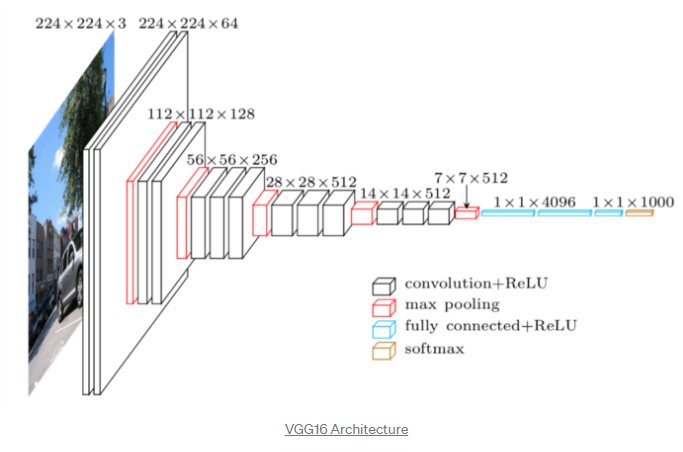

**Preparing the dataset**

In [4]:
from keras.preprocessing import image
import os,numpy as np

2025-05-26 20:14:46.029788: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 20:14:46.031042: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 20:14:46.034840: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 20:14:46.049681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 20:14:46.074587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [5]:
dataset_folder = "dataset/"
label_ref = {"damage":0,"no_damage":1}

In [6]:
img_features = []
label = []
for folder_name in os.listdir(dataset_folder):
  for image_name in os.listdir(dataset_folder+folder_name):
      #reshaping the images to 224x224x3 (same as vgg16)
      try:
        image_array = image.load_img(dataset_folder+folder_name+"/"+image_name,target_size=(224,224))
      except Exception as e:
        print(f"Error loading image {dataset_folder +folder_name +image_name}: {e}")
      image_array = image.img_to_array(image_array)
      img_features.append(image_array)
      label.append(label_ref[folder_name])

In [7]:
img_features = np.array(img_features, dtype="float32")
img_features.shape 

(2000, 224, 224, 3)

In [8]:
label = np.array(label, dtype="int")
label.shape

(2000,)

In [9]:
#train (90 %), test (10 %) datapoints
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(img_features, label, test_size=0.10, random_state=42)

In [10]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1800, 224, 224, 3), (200, 224, 224, 3), (1800,), (200,))

**Feature extraction**

In [11]:
import keras, pandas as pd
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [12]:
#loading VGG16 model weights
model_vgg = VGG16(weights='imagenet', include_top=False)

2025-05-26 20:14:55.777762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-26 20:14:55.844779: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
train_x = preprocess_input(train_x)
train_x.shape

(1800, 224, 224, 3)

In [14]:
#Extracting features from the train dataset using the VGG16 pre-trained model
train_x=model_vgg.predict(train_x)
train_x.shape 

57/57 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step


(1800, 7, 7, 512)

In [15]:
#reshaping the input image to 25088 (7*7*512)
train_x = train_x.reshape(train_x.shape[0],25088)

In [16]:
#performing one-hot encoding for the target variable
train_y = pd.get_dummies(train_y)
train_y = np.array(train_y)

In [17]:
train_x.shape, train_y.shape

((1800, 25088), (1800, 2))

**Training the Multilayer perceptron and using it after 7x7x512 max pooling layer**

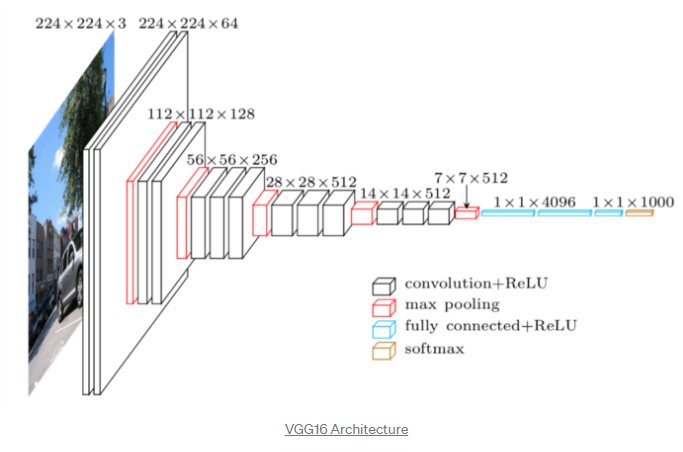

In [18]:
model = Sequential()
model.add(Dense(1000, input_dim=25088, activation='relu',kernel_initializer='uniform'))
# keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)
model.add(Dropout(0.3))

model.add(Dense(500,input_dim=1000,activation='sigmoid'))
# keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)
model.add(Dropout(0.4))

model.add(Dense(150,input_dim=500,activation='sigmoid'))
# keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)
model.add(Dropout(0.2))

model.add(Dense(units=2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

/home/sai/Documents/Hurricane_damage_classification/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#train the model
model.fit(train_x, train_y, epochs=25, batch_size=64)

Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.7293 - loss: 0.5142
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9730 - loss: 0.0896
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9937 - loss: 0.0315
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 1.0000 - loss: 0.0057
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 1.0000 - loss: 7.1331e-04
Epoch 8/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 1.0000 - loss: 4.6548e-04
Epoch 9/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 1.0000 - loss: 4.2738e-04
Epoch 10/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 1.0000 - loss: 3.2994e-04
Epoch 11/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 3.3250e-04
Epoch 12/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s

In [21]:
#saving model
model.save('image_classification_model.keras')  # or .h5 or use .export()

**Evalution on test datapoints**

In [22]:
len(test_x),len(test_y)

(200, 200)

In [23]:
test_x = preprocess_input(test_x)
test_x.shape

(200, 224, 224, 3)

In [24]:
#Extracting features from the train dataset using the VGG16 pre-trained model
test_x = model_vgg.predict(test_x)
test_x.shape 

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


(200, 7, 7, 512)

In [25]:
#reshaping the input image to 25088 (7*7*512)
test_x = test_x.reshape(test_x.shape[0],25088)

In [26]:
#performing one-hot encoding for the target variable
test_y=pd.get_dummies(test_y)
test_y=np.array(test_y)

In [27]:
test_x.shape, test_y.shape

((200, 25088), (200, 2))

In [28]:
#test accuracy
model.evaluate(test_x,test_y)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9580 - loss: 0.2746


[0.19945408403873444, 0.9700000286102295]